# Building a survival model for the Titanic Kaggle competition

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Importing the data

In [2]:
# Read data out into train and test dataframes
train = pd.read_csv('../data/train.csv', index_col='PassengerId')
test = pd.read_csv('../data/test.csv', index_col='PassengerId')

## Exploring the data

In [3]:
# Print out the top 5 rows of the training data
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Look at the columns present in both training and test data to see if any columns are different between them
print('Train data columns: ', train.columns)
print('Test data columns: ', test.columns)

Train data columns:  Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Test data columns:  Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')


In [5]:
# look at the datatypes and null values for the training data
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


From this information we can see that most columns have complete values. The cabin column appears to have the most values missing with only 204 out of 891 that have a non-null value. For this reason we should drop this column. The column for Age seems to have a number of value missing. Here we may want to use the average age to fill these empty entries if we deem this an important feature. Age and Fare are both Float values.

Categorical columns:  ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']  Surived is also a categorical column as it's values are 1 for survived and 0 for died.
    
    

In [6]:
train = train.drop('Cabin', axis=1)

### Age of Passengers on the Titanic

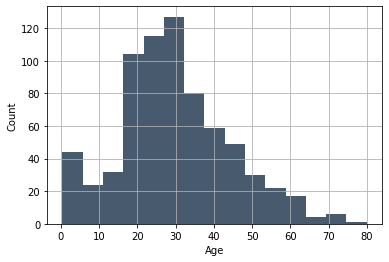

In [7]:
ax = train["Age"].hist(bins=15, color='#34495e', alpha=0.9)
ax.set(xlabel='Age', ylabel='Count')
plt.show()

Looking at this graph the age is slightly skewed so we would be better to replace the missing values with the median not the mean.

In [8]:
train['Age'] = train['Age'].fillna(train['Age'].median())
train['Age'].describe()

count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

### Passengers travelling with family members

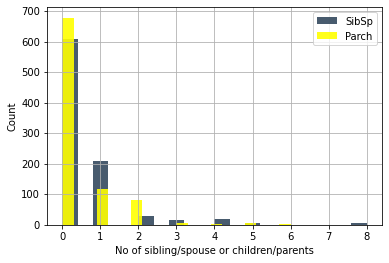

In [9]:
ax = train["SibSp"].hist(bins=20, color='#34495e', alpha=0.9, label='SibSp')
ax = train["Parch"].hist(bins=20, color='yellow', alpha=0.9, label='Parch')
ax.set(xlabel='No of sibling/spouse or children/parents', ylabel='Count')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.show()

We can see most people travelled alone with no children, parents, siblings or spouse on board. Lets create some features from this information, starting with a column to denote if a passenger was traveling alone or not.

In [10]:
def if_alone(row):
    if (row['SibSp'] == 0) and (row['Parch'] == 0):
        return 1
    return 0

train['Alone'] = train.apply(if_alone, axis='columns')
train['Alone'][0:5]

PassengerId
1    0
2    0
3    1
4    0
5    1
Name: Alone, dtype: int64

Let's go a head an make a column for family size which sums the siblings, spouse, children, parents plus the passenger.

In [11]:
def family_size(row):
    if row['Alone'] == 0:
        return row['SibSp'] + row['Parch'] + 1
    return 0

train['FamilySize'] = train.apply(family_size, axis='columns')
train['FamilySize'].describe()

count    891.000000
mean       1.301908
std        1.983581
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max       11.000000
Name: FamilySize, dtype: float64

Most families were rather small but there was at least one with 11 family members onboard!

## Exploring survival on the Titanic

### Survival and Fare paid

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Fare, dtype: object

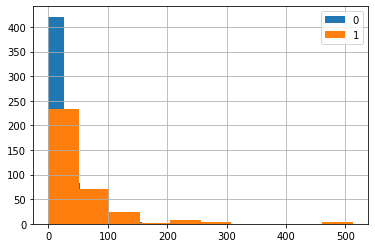

In [12]:
train.groupby('Survived').Fare.hist(legend=True)  # 0 == Died, 1 == Survived

In [13]:
x = train.groupby('Survived').Fare.describe()

Those who paid a very low fare are more represented in the group which did not survive. In the group of those who survived we see a wider spread of fares and all the higher fares are from passengers who survived. On average those who survived had paid more on their fare than those who did not. This is also represented in the chart below where we plot the fare against age. 

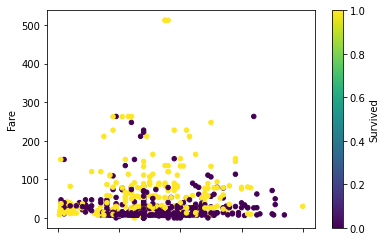

In [14]:
ax2 = train.plot.scatter(x='Age',
                      y='Fare',
                      c='Survived',
                      colormap='viridis')

This chart suggests that survival was fairly spread out when it came to age, let's check that.

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Age, dtype: object

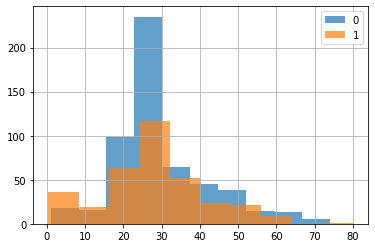

In [15]:
train.groupby('Survived').Age.hist(legend=True, alpha=0.7) # 0 == Died, 1 == Survived

We do see that the spread is rather wide but there is a peak in the group aged 0-10 which could confrim the aledged policy of Women & children first.

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Age, dtype: object

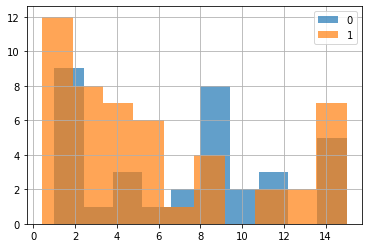

In [16]:
children_data = train[train['Age'] < 16]
children_data.groupby('Survived').Age.hist(legend=True, alpha=0.7) # 0 == Died, 1 == Survived

<AxesSubplot:xlabel='Survived', ylabel='count'>

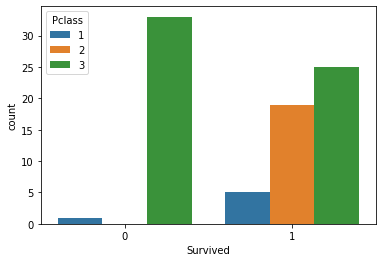

In [17]:
sns.countplot(x='Survived',hue='Pclass',data=children_data)

### Survival and Sex of passengers

<AxesSubplot:xlabel='Sex', ylabel='count'>

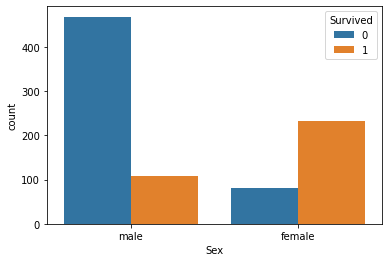

In [18]:
sns.countplot(x='Sex',hue='Survived',data=train)

In [19]:
print(train.groupby(['Sex', 'Pclass']).mean()['Survived'])
print(train.groupby(['Sex', 'Pclass']).std()['Survived'])

Sex     Pclass
female  1         0.968085
        2         0.921053
        3         0.500000
male    1         0.368852
        2         0.157407
        3         0.135447
Name: Survived, dtype: float64
Sex     Pclass
female  1         0.176716
        2         0.271448
        3         0.501745
male    1         0.484484
        2         0.365882
        3         0.342694
Name: Survived, dtype: float64


In [20]:
#Number of Female passengers
female_passengers = train.loc[train['Sex'] == 'female']
print('Number of female passengers in training data: ', len(female_passengers))

# Number of female passengers under 18
female_passengers_under_18 = female_passengers.loc[female_passengers['Age'] < 18]
print('Number of female passengers under 18 in training data: ', len(female_passengers_under_18))

# Number of female passengers over 60
female_passengers_over_60 = female_passengers.loc[female_passengers['Age'] > 60]
print('Number of female passengers over 60 in training data: ', len(female_passengers_over_60))

# Number of female passengers traveling alone
female_passengers_parch = female_passengers.loc[female_passengers['Alone'] == 1]
print('Number of female passengers traveling alone in training data: ', len(female_passengers_parch))

# Number of female passengers traveling with a parent or child
female_passengers_parch = female_passengers.loc[female_passengers['Parch'] >= 1]
print('Number of female passengers traveling with a parent or child in training data: ', len(female_passengers_parch))

# Number of female passengers traveling with a sibling or spouse
female_passengers_with_sibsp = female_passengers.loc[female_passengers['SibSp'] >= 1]
print('Number of female passengers traveling with a sibling or spouse in training data: ', len(female_passengers_with_sibsp))

# Number of female passengers who surrived
female_passengers_that_survived = female_passengers.loc[female_passengers['Survived'] == 1]
print('Number of female passengers that survived in training data: ', len(female_passengers_that_survived))

# Percentage of female passengers that surived f'{x:.0%}'
print('Precentage of female passengers that survived in training data: ', f'{len(female_passengers_that_survived)/len(female_passengers)*100:.1f}%')

Number of female passengers in training data:  314
Number of female passengers under 18 in training data:  55
Number of female passengers over 60 in training data:  3
Number of female passengers traveling alone in training data:  126
Number of female passengers traveling with a parent or child in training data:  120
Number of female passengers traveling with a sibling or spouse in training data:  140
Number of female passengers that survived in training data:  233
Precentage of female passengers that survived in training data:  74.2%


### Survival and Class on the Titanic

<AxesSubplot:xlabel='Survived', ylabel='count'>

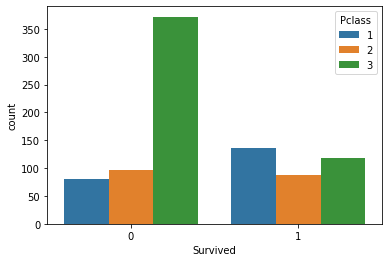

In [21]:
sns.countplot(x='Survived',hue='Pclass',data=train)

Here we can see many more 3rd class passengers died than 1st class passengers.

### Looking at the relationship class and sex has on survival on the Titanic

<AxesSubplot:xlabel='Survival,Class,Sex'>

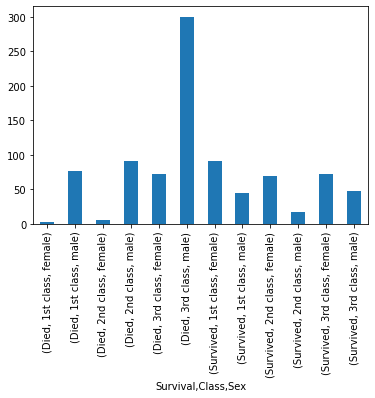

In [22]:
train['Survival'] = train.Survived.map(lambda t: 'Survived' if t == 1 else 'Died')
train['Class'] = train.Pclass.map(lambda t: '1st class' if t == 1 else ('2nd class' if t == 2 else '3rd class'))

(train
.groupby(['Survival', 'Class', 'Sex'])
.Class
.count()
.plot(kind='bar')
)

The largest group from the Titanic by far was 3rd class males who died by quite a gap. We can also see that females in 1st and 2nd class more often survived than died but females from 3rd class appear to be split in half between those which survived and those who did not.

### Survival and where passengers embarked on the Titanic

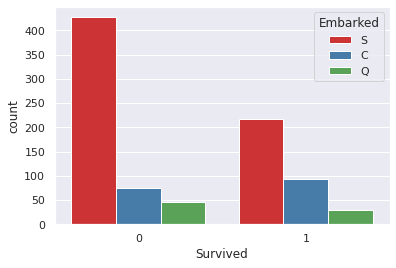

In [23]:
sns.set(style="darkgrid")
sns.countplot( x='Survived', data=train, hue="Embarked", palette="Set1");

Generally the distribution is similar between the passengers how survived and those who didn't when it comes to location of embarkment. There is however slightly more of the people who embarked at C in the group which survived which perhaps suggests some advantage. Again it could be indirect, perhaps those that joined there were part of the 1st class for example.

### Survival and travelling with relatives on the Titanic

<AxesSubplot:xlabel='FamilySize', ylabel='count'>

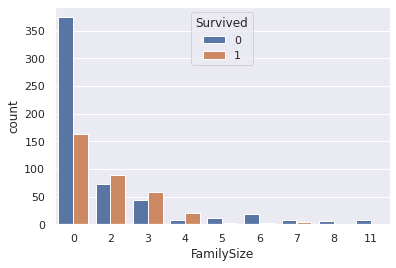

In [24]:
sns.countplot(x='FamilySize',hue='Survived',data=train)

<AxesSubplot:xlabel='Alone', ylabel='count'>

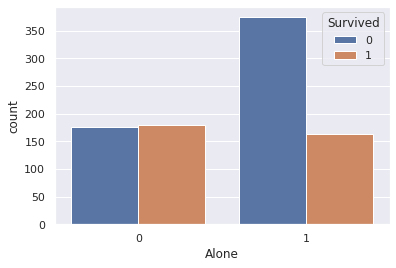

In [25]:
sns.countplot(x='Alone',hue='Survived',data=train)

We see here that there are slightly more survivers in the group who were traveling alone and only a few survivors who were traveling in a larger family group. Pointing towards this as a potentially important feature for our model.

### Just a name? Is there any correlation between a passengers name their chances of survival?

In [26]:
# Extract surname into separate column
train['Surname'] = train['Name'].map(lambda x: x.split(',')[0])
print(train['Surname'][0:5])

PassengerId
1       Braund
2      Cumings
3    Heikkinen
4     Futrelle
5        Allen
Name: Surname, dtype: object


<AxesSubplot:xlabel='No of passenger with same surname', ylabel='count'>

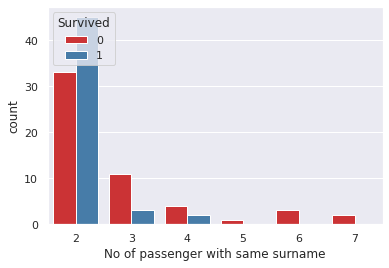

In [27]:
surnames_count = (
 train
 .groupby(['Surname', 'Survived', 'Pclass'])
 [['Surname']]
 .count()
 .sort_values(ascending=False, by='Survived')
)

surnames_count = surnames_count.loc[surnames_count['Surname'] > 1] # filter out only surnames with more than one passenger

surnames_count.reset_index(level=1, inplace=True) # move the survived index to a column so we can plot it
surnames_count = surnames_count.rename(columns={"Surname": "No of passenger with same surname"}, errors="raise")

sns.countplot( x='No of passenger with same surname', data=surnames_count, hue='Survived', palette="Set1")

This chart matches quite well the one we have for families, this is not suprising as they are the one's most likley to share a surname. Again we can summise that those in larger groups were less likely to be in the group which survived.

<AxesSubplot:xlabel='No of passenger with same surname', ylabel='count'>

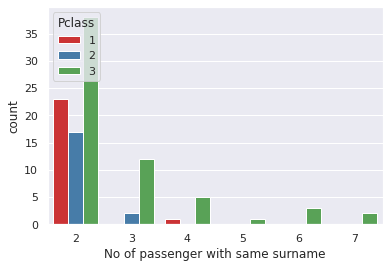

In [28]:
surnames_count.reset_index(level=1, inplace=True) # move the survived index to a column so we can plot it
sns.countplot( x='No of passenger with same surname', data=surnames_count, hue='Pclass', palette="Set1")

If we look at the surnames that were shared with the most passengers we can see they are predominently 3rd class, which points to larger family groups travelling together. This may indirectly be the reason that more popular surnames (ie those that more passengers had) were in the group which died.

In [29]:
# Extract first name into separate column
train['First_names'] = train['Name'].map(lambda x: x.split('.')[1].split('(')[0].strip())
print(train['First_names'][0:5])

PassengerId
1      Owen Harris
2     John Bradley
3            Laina
4    Jacques Heath
5    William Henry
Name: First_names, dtype: object


In [30]:
(train
.groupby(['Survived', 'First_names'])
.First_names
.count()
.sort_values(ascending=False)
[:10]
)

Survived  First_names  
1                          13
0         John             10
          William           9
          James             7
1         Bertha            4
0         Joseph            4
          William Henry     3
          Tannous           3
          Thomas            3
1         Mary              3
Name: First_names, dtype: int64

In [31]:
len(train.loc[train['First_names'] == 'John'])

10

While it remains unlikely someone's first name would play a role in their survival on the Titanic interesting all of the passengers in the training data called John died. This isn't statistically so suprising as they were most likely male passengers and we've already discovered male passengers were predominently in the group which died. It may point to patterns in the names given to different classes if indeed such a thing existed.

### Passenger Title

In [32]:
# Extract title into separate column
train['Title'] = train['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
train['Title'] = train['Title'].map(lambda x: 'Countess' if x == 'the Countess' else x)
for title in train['Title'].unique():
    print(title, train.loc[(train['Title'] == title)].Title.count())

Mr 517
Mrs 125
Miss 182
Master 40
Don 1
Rev 6
Dr 7
Mme 1
Ms 1
Major 2
Lady 1
Sir 1
Mlle 2
Col 2
Capt 1
Countess 1
Jonkheer 1


* Mlle     == Mademoiselle.
* Don      == A head, tutor, or fellow at a college of Oxford or Cambridge. Or title for males in spanish speaking areas.
* Mme      == Madam.
* Jonkheer == An honorific in the Low Countries denoting the lowest rank within the nobility.

It may be worth grouping some of these unless they had significant affect on whether someone was in the survived group but as we've seen in previous analysis it appears Sex was the more important feature.

<AxesSubplot:title={'center':'Title distribution of those who died on the Titanic'}, xlabel='Title'>

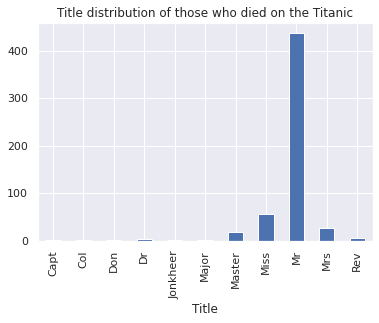

In [33]:
plt.title('Title distribution of those who died on the Titanic')
(train[train.Survived == 0]
.groupby(['Title'])
.Title
.count()
.plot(kind='bar')
)

<AxesSubplot:title={'center':'Title distribution of those who survived on the Titanic'}, xlabel='Title'>

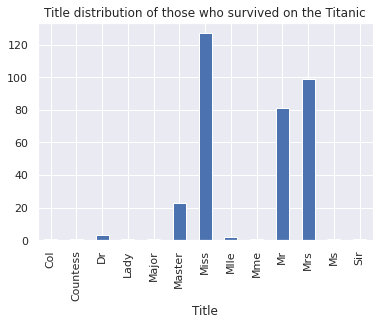

In [34]:
plt.title('Title distribution of those who survived on the Titanic')
(train[train.Survived == 1]
.groupby(['Title'])
.Title
.count()
.plot(kind='bar')
)

We certainly see more of the titels that belong to females in the survived group.

### Ticket Type

In [35]:
# Extract the ticket type (assuming potentially where they bought the ticket) from the ticket value
train['Ticket_type'] = train['Ticket'].map(lambda x: x.split()[0] if any(c.isalpha() for c in x.split()[0]) else 'Unknown')
print(train['Ticket_type'].unique())

print(train['Ticket_type'].describe())
unknown_ticket_type = train[train['Ticket_type'] == 'Unknown']['Ticket_type'].count()
print('No of unknown ticket type', unknown_ticket_type)
print('Percentage of unknown ticket type', f'{(unknown_ticket_type/ 891)*100:.1f}%')

['A/5' 'PC' 'STON/O2.' 'Unknown' 'PP' 'A/5.' 'C.A.' 'A./5.' 'SC/Paris'
 'S.C./A.4.' 'A/4.' 'CA' 'S.P.' 'S.O.C.' 'SO/C' 'W./C.' 'SOTON/OQ'
 'W.E.P.' 'STON/O' 'A4.' 'C' 'SOTON/O.Q.' 'SC/PARIS' 'S.O.P.' 'A.5.' 'Fa'
 'CA.' 'LINE' 'F.C.C.' 'W/C' 'SW/PP' 'SCO/W' 'P/PP' 'SC' 'SC/AH' 'A/S'
 'A/4' 'WE/P' 'S.W./PP' 'S.O./P.P.' 'F.C.' 'SOTON/O2' 'S.C./PARIS'
 'C.A./SOTON']
count         891
unique         44
top       Unknown
freq          661
Name: Ticket_type, dtype: object
No of unknown ticket type 661
Percentage of unknown ticket type 74.2%


With such a large about of the ticket type being unknown it's unlikley this column will be a useful feature and we can drop it. Let's check this first by ploting the unknow tickets and the known ones by survival.

<AxesSubplot:xlabel='Survived'>

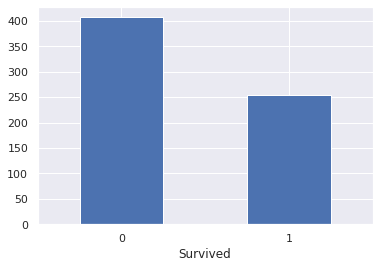

In [36]:
 train[train['Ticket_type'] == 'Unknown'].groupby(['Survived'])['Ticket_type'].count().plot(kind='bar', rot=0)

<AxesSubplot:xlabel='Survived'>

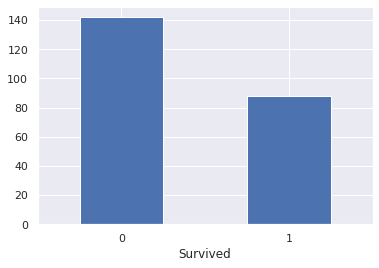

In [37]:
 train[train['Ticket_type'] != 'Unknown'].groupby(['Survived'])['Ticket_type'].count().plot(kind='bar', rot=0)

In [38]:
train = train.drop('Ticket_type', axis=1)
train = train.drop('Ticket', axis=1)
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Alone', 'FamilySize', 'Survival', 'Class', 'Surname',
       'First_names', 'Title'],
      dtype='object')

## Creating a model

Let's start building a model with the features we have identified as being important.

In [39]:
# Put feature columns into X_train dataframe
base_features = ['Pclass', 'Sex', 'Age', 'Alone', 'FamilySize', 'Fare', 'Embarked', 'Title']
X_train = train[base_features].copy()
X_train.index = train.index
# Put survival value into y
y = train['Survived']

print(y.head())
X_train.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64


,Pclass,Sex,Age,Alone,FamilySize,Fare,Embarked,Title
PassengerId,,,,,,,,
1,3,male,22.0,0,2,7.2500,S,Mr
2,1,female,38.0,0,2,71.2833,C,Mrs
3,3,female,26.0,1,0,7.9250,S,Miss
4,1,female,35.0,0,2,53.1000,S,Mrs
5,3,male,35.0,1,0,8.0500,S,Mr


### Handling categorical data

In [40]:
# Look at what data is categorical data
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)
print(object_cols)

['Sex', 'Embarked', 'Title']


In [41]:
# Update the Embarked column to replace nan values with unknown
X_train['Embarked'] = X_train['Embarked'].fillna('unknown')

print(X_train['Embarked'].unique())

['S' 'C' 'Q' 'unknown']


In [42]:
# Update the Age column to replace nan values with the mean value
X_train['Age'].fillna(X_train['Age'].mean(), inplace=True)

In [43]:
# Check cardinality of categorical variables
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))
# Print in ascending order
sorted(d.items(), key=lambda x: x[1])

# We can conclude that for those with low cardinality we can use one-hot encoding and for the time being I am dropping those with high cardinality

[('Sex', 2), ('Embarked', 4), ('Title', 17)]

In [44]:
# Assign categorical data columns to low or high cardinality lists
low_cardinality = ['Title', 'Sex', 'Embarked']

In [45]:
# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
# for col in high_cardinality:
#     X_train[col] = label_encoder.fit_transform(X_train[col])

X_train.head()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Sex         891 non-null    object 
 2   Age         891 non-null    float64
 3   Alone       891 non-null    int64  
 4   FamilySize  891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Embarked    891 non-null    object 
 7   Title       891 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 102.6+ KB


In [46]:
from sklearn.preprocessing import OneHotEncoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality]))
OH_cols_train.columns = OH_encoder.get_feature_names()
print('OH_cols_train: ', OH_cols_train.columns.tolist(), ' shape ', OH_cols_train.shape)
non_oh_encoded = X_train.drop(low_cardinality, axis=1)
OH_cols_train.index = X_train.index
print('non_oh_encoded: ', non_oh_encoded.columns.tolist(), ' shape ', non_oh_encoded.shape)
OH_X_train = pd.concat([non_oh_encoded, OH_cols_train], axis=1)
OH_X_train.index = X_train.index
print('OH_X_train: ', OH_X_train.columns.tolist(), ' shape ', OH_X_train.shape)
OH_X_train.columns

OH_cols_train:  ['x0_Capt', 'x0_Col', 'x0_Countess', 'x0_Don', 'x0_Dr', 'x0_Jonkheer', 'x0_Lady', 'x0_Major', 'x0_Master', 'x0_Miss', 'x0_Mlle', 'x0_Mme', 'x0_Mr', 'x0_Mrs', 'x0_Ms', 'x0_Rev', 'x0_Sir', 'x1_female', 'x1_male', 'x2_C', 'x2_Q', 'x2_S', 'x2_unknown']  shape  (891, 23)
non_oh_encoded:  ['Pclass', 'Age', 'Alone', 'FamilySize', 'Fare']  shape  (891, 5)
OH_X_train:  ['Pclass', 'Age', 'Alone', 'FamilySize', 'Fare', 'x0_Capt', 'x0_Col', 'x0_Countess', 'x0_Don', 'x0_Dr', 'x0_Jonkheer', 'x0_Lady', 'x0_Major', 'x0_Master', 'x0_Miss', 'x0_Mlle', 'x0_Mme', 'x0_Mr', 'x0_Mrs', 'x0_Ms', 'x0_Rev', 'x0_Sir', 'x1_female', 'x1_male', 'x2_C', 'x2_Q', 'x2_S', 'x2_unknown']  shape  (891, 28)


Index(['Pclass', 'Age', 'Alone', 'FamilySize', 'Fare', 'x0_Capt', 'x0_Col',
       'x0_Countess', 'x0_Don', 'x0_Dr', 'x0_Jonkheer', 'x0_Lady', 'x0_Major',
       'x0_Master', 'x0_Miss', 'x0_Mlle', 'x0_Mme', 'x0_Mr', 'x0_Mrs', 'x0_Ms',
       'x0_Rev', 'x0_Sir', 'x1_female', 'x1_male', 'x2_C', 'x2_Q', 'x2_S',
       'x2_unknown'],
      dtype='object')

## Training our model and making predictions

In [47]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(OH_X_train, y, random_state = 0)

In [48]:
val_X.dropna(axis=0, how='any', inplace=True)

<ipython-input-48-b3c74f6ec8dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.dropna(axis=0, how='any', inplace=True)


In [49]:
print(train_X.columns)

Index(['Pclass', 'Age', 'Alone', 'FamilySize', 'Fare', 'x0_Capt', 'x0_Col',
       'x0_Countess', 'x0_Don', 'x0_Dr', 'x0_Jonkheer', 'x0_Lady', 'x0_Major',
       'x0_Master', 'x0_Miss', 'x0_Mlle', 'x0_Mme', 'x0_Mr', 'x0_Mrs', 'x0_Ms',
       'x0_Rev', 'x0_Sir', 'x1_female', 'x1_male', 'x2_C', 'x2_Q', 'x2_S',
       'x2_unknown'],
      dtype='object')


In [50]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(train_X, train_y.values.ravel())

RandomForestClassifier(random_state=0)

In [51]:
predictions = rf_model.predict(val_X)

In [52]:
print(predictions[0:5])
print(val_y[0:5])
print(f'Accuracy: {rf_model.score(val_X, val_y):.2f}%')

[0 0 0 1 1]
PassengerId
496    0
649    0
279    0
32     1
256    1
Name: Survived, dtype: int64
Accuracy: 0.84%


## Evaluating our model

### Permutation importance of features

In [53]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf_model, random_state=1).fit(val_X, val_y)

eli5.show_weights(perm, feature_names=val_X.columns.tolist())

/home/sleepypioneer/IdeaProjects/titanic_project/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/sleepypioneer/IdeaProjects/titanic_project/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.0574 ± 0.0237,Pclass
0.0341 ± 0.0231,Age
0.0251 ± 0.0270,Fare
0.0242 ± 0.0257,x1_male
0.0197 ± 0.0166,FamilySize
0.0152 ± 0.0146,x1_female
0.0135 ± 0.0113,x0_Mr
0.0126 ± 0.0154,x0_Mrs
0.0036 ± 0.0036,x0_Rev
0.0018 ± 0.0091,x0_Master


Interestingly 'Alone' does not appear here, suggesting it has much less importance than previously thought.

### Partial dependence plots

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


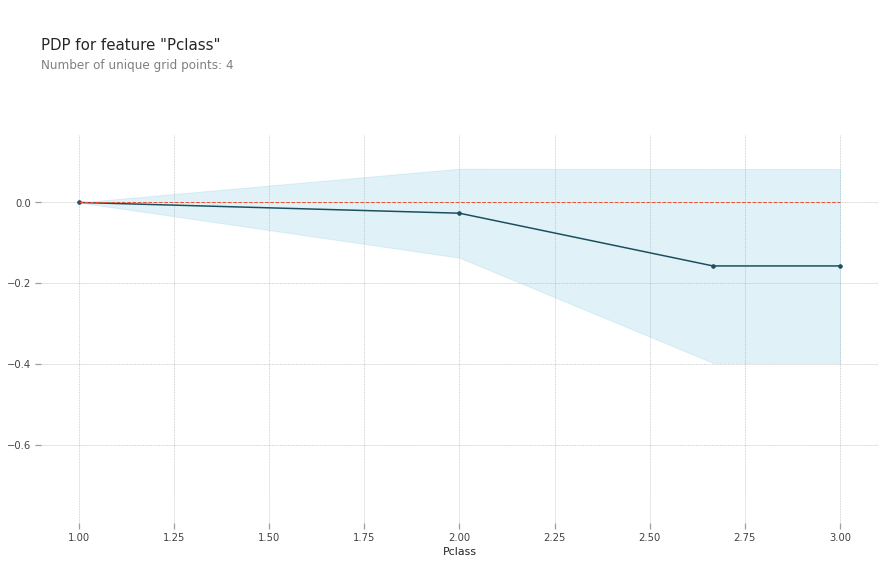

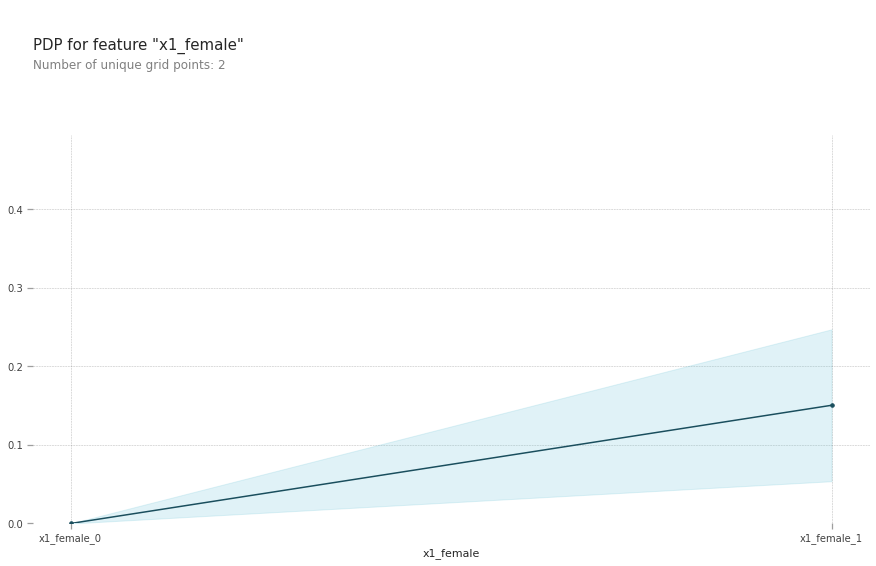

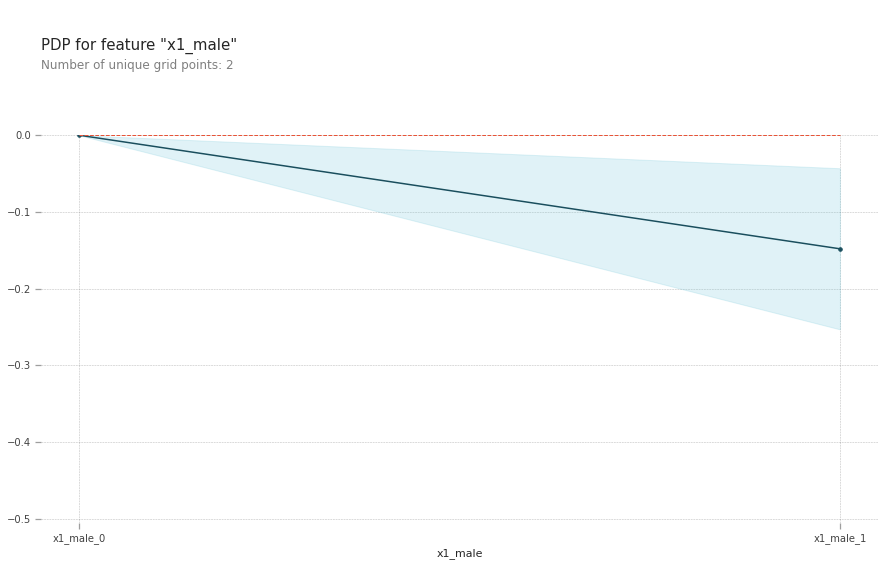

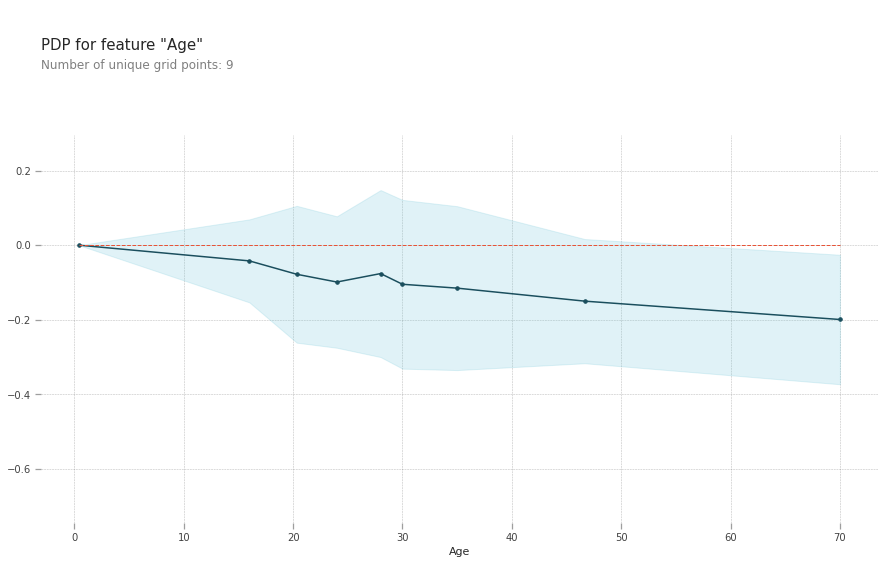

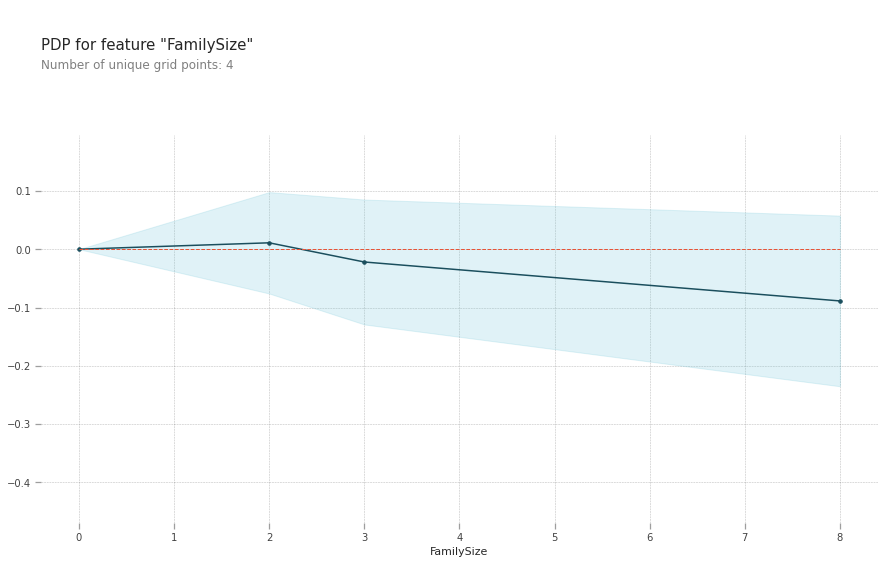

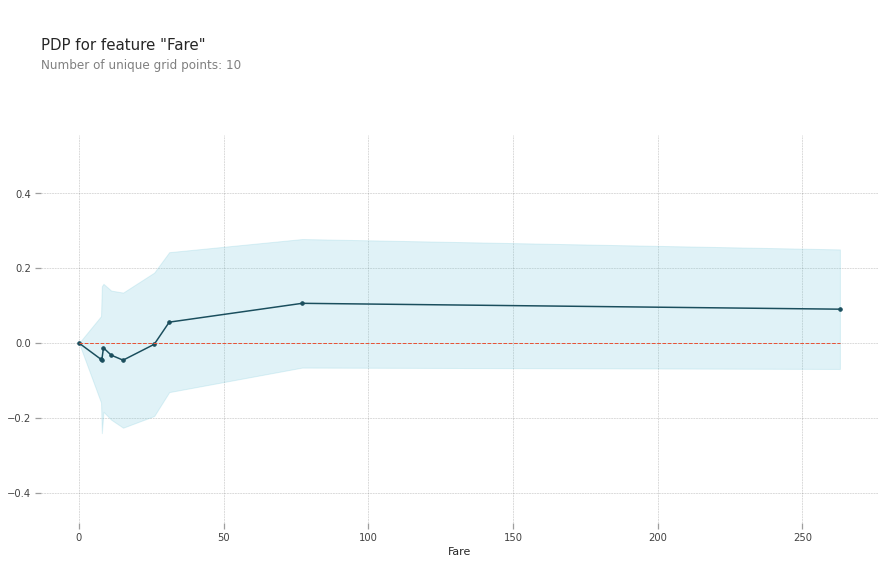

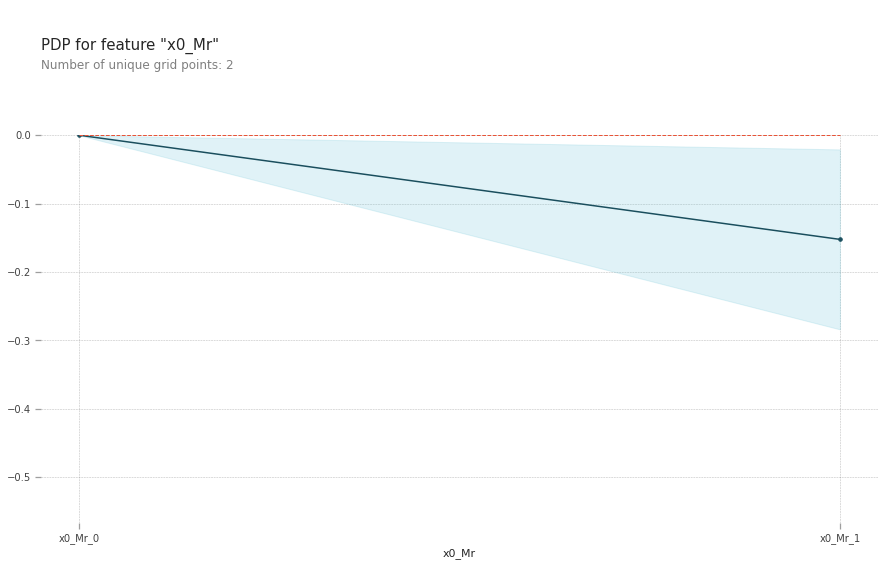

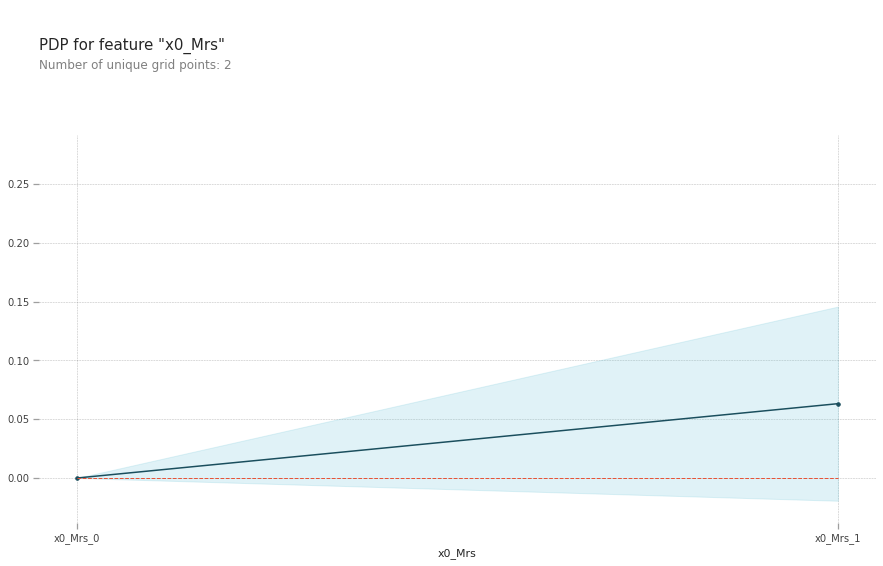

In [54]:
from pdpbox import pdp, get_dataset, info_plots

important_features = ['Pclass', 'x1_female', 'x1_male', 'Age', 'FamilySize', 'Fare', 'x0_Mr', 'x0_Mrs']

for feature_name in important_features:
    pdp_goals = pdp.pdp_isolate(model=rf_model, dataset=val_X, model_features=val_X.columns.tolist(), feature=feature_name)
    pdp.pdp_plot(pdp_goals, feature_name)
    plt.show()

### 2D Partial Dependance Plots

In [57]:
# inter1 = pdp.pdp_interact(model=rf_model, dataset=val_X, model_features=val_X.columns.tolist(), features=important_features)
# pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=val_X.columns.tolist(), plot_type='contour')
# plt.show()

### SHAP Values
break down a prediction to show the impact of each feature.

In [58]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


rf_model.predict_proba(data_for_prediction_array)

array([[0.49016667, 0.50983333]])

In [59]:
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
data_for_prediction = val_X.iloc[1]
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction) # looking at values for those that surrived
#  Shap values show how much a given feature changed our prediction (compared to if we made that prediction at some baseline value of that feature).

Here we see that if you were male and in 3rd class the model was most accurate, most likely because the largest amount of this group did not survivce on the Titanic.

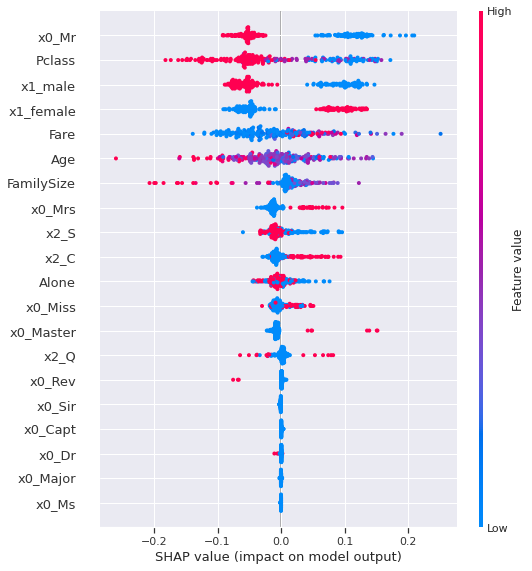

In [60]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X)

Again here we see the clearest definition is when we know if a pasenger had the title Mr, their class, and wether they were male (more likely to die), or female (more likely to survive) Fare and age appear to have much less impact on the model. The title at the bottom seem to have little impact and potentially are still worth grouping.

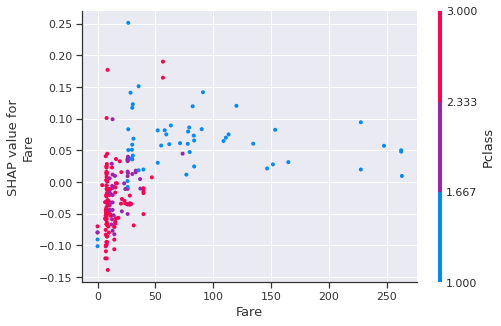

In [61]:
# make plot.
shap.dependence_plot('Fare', shap_values[1], val_X, interaction_index="Pclass")

Here we see that the higher fares belonged to passengers in first class which makes sense.

## Refining our model

In [62]:
selected_features = ['Pclass', 'x1_female', 'x1_male', 'Age', 'FamilySize', 'Fare', 'x0_Mr', 'x0_Mrs']

from sklearn.model_selection import train_test_split
train_reduced_features_X, val_reduced_features_X, train_reduced_features_y, val_reduced_features_y = train_test_split(OH_X_train[selected_features], y, random_state = 0)
val_X.dropna(axis=0, how='any', inplace=True)

from sklearn.ensemble import RandomForestClassifier
rf_reduced_features_model = RandomForestClassifier(random_state=0)
rf_reduced_features_model.fit(train_reduced_features_X, train_reduced_features_y.values.ravel())

predictions = rf_reduced_features_model.predict(val_reduced_features_X)

print('Predictions: ', predictions[0:5])
print('Y Values: ', val_reduced_features_y[0:5])
print(f'Accuracy: {rf_reduced_features_model.score(val_reduced_features_X, val_reduced_features_y):.2f}%')

Predictions:  [0 0 0 1 0]
Y Values:  PassengerId
496    0
649    0
279    0
32     1
256    1
Name: Survived, dtype: int64
Accuracy: 0.85%


By taking only the most important features we have slightly improved the accuracy of our model.

## Building a prediction function 

In [63]:
pd.options.display.max_rows
pd.set_option('display.max_rows', None)
test_character = pd.DataFrame([val_reduced_features_X.iloc[3]], columns=important_features)
print(test_character)

    Pclass  x1_female  x1_male   Age  FamilySize      Fare  x0_Mr  x0_Mrs
32     1.0        1.0      0.0  28.0         2.0  146.5208    0.0     1.0


In [64]:
prediction = rf_reduced_features_model.predict(test_character)
if prediction[0] == 0:
    print('Sorry you died')
else:
    print('You survived!')


You survived!


In [65]:
# export model
import joblib
joblib.dump(rf_model, "../../src/artifacts/titanic_clf.joblib")

['../../src/artifacts/titanic_clf.joblib']